## Upload B cells clones by Hamming

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from Bio.Seq import Seq

from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import string
from itertools import cycle
from six.moves import zip



def label_axes(fig, labels=None, loc=None, **kwargs):
    if labels is None:
        labels = string.ascii_uppercase
        
    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (0.0, 1.02)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc, fontsize = 22,
                    xycoords='axes fraction',weight = "bold",
                    **kwargs)

def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'
    
def prot (x):
    x = x.replace('-','')
    if (x.find('.')>-1):
        x = x[:x.find('.')]
    return str(Seq(x).translate())

In [2]:
path = '/home/bcrlab/sharaboc/'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

print ("Upload file..")
fil = pd.read_csv(path+"/clones/clones_hamming_no_isotype.csv",sep = '\t')

def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

print ("Modify categories..")
fil['SHORT_J'] = fil.J_CALL.apply(v1)
fil['SHORT_V'] = fil.V_CALL.apply(v1)

fil = fil[fil['PRIMER'].str[:4] !='IGLC']
fil = fil[fil['FUNCTIONAL'] !='F']
fil = fil[fil.INDELS =='F']
#fil = fil[fil.CONSCOUNT>1]

fil['VJ'] = fil['SHORT_V']+'*'+fil['SHORT_J'] 
fil['VJL'] = fil['SHORT_V']+'*'+fil['SHORT_J'] +'*'+fil['JUNCTION_LENGTH'].astype(str)

fil = fil[fil['VJ'] != 'IGHV3-15*IGHJ6']
fil = fil[fil['JUNCTION_LENGTH'] >12]
fil = fil[fil.JUNCTION_LENGTH%3 ==0 ]

Upload file..
Modify categories..


In [3]:
def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

#fil = fil[fil.SUBJECT.apply(by_symp)!='C']

In [4]:
def reduce2(fn):
    fn = fn[fn.symp!='C']
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<7].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def reduce1(fn,category):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<5].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def reduce3(fn):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<7].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

In [5]:
category = 'clon' #Change category by V/  VJ / CLONE..
ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
#fn = fn[fn['DUPCOUNT']>1]
tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
fn = fn.fillna(0)

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

fn['symp'] = fn['SUBJECT'].apply(by_symp)
np.shape(reduce1(fn,'clon'))

(26, 124)

In [16]:
sns.clustermap(fn.set_index('SUBJECT').iloc[:,:-1].corr('spearman'))
plt.show()

MemoryError: 

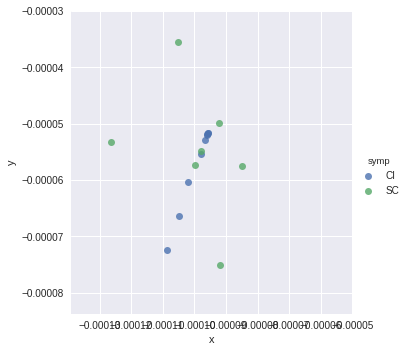

In [501]:
fil_best = pd.read_csv(path+"ML_results/B_10_best_features",sep = ',').set_index('Importance_rank')
ll = list(fil_best.reset_index()['clone'].apply(lambda x: x[:x.find('.')] +'-'+x[x.find('.')+1:].replace('.','*')))
fn1 = fn[['SUBJECT'] +ll +['symp']]
fn1 = fn1[fn1.symp !='C']
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)


X = fn1.iloc[:,1:-1]
Y = fn1.iloc[:,-1:]
pca.fit(X)

df_vals = pd.DataFrame(pca.transform(X))

df_comb = Y.reset_index().merge(df_vals,right_index=True,left_index=True)

g1 = sns.lmplot("x","y",data=df_comb.rename(columns={0:"x",1:"y"}) , hue = 'symp',fit_reg=False)
g1.ax.set_ylim((df_comb[1].min()*1.1,df_comb[1].max()*0 -0.00003)) # change Y range
g1.ax.set_xlim((df_comb[0].min()*1.1,df_comb[0].max()*0 -0.00005)) #change X range
plt.show()

## Junction's double/triple AA features

In [394]:
from collections import Counter

dict_aa_group = {'F':'Z' , 'W': 'Z', 'Y': 'Z' , 'D' : '-' , 'E': '-',
                 'K':'+' , 'R':'+','N':'N','Q':'<','S':'S','M':'>',
                 'L':'>','V':'>','I':'>','A':'A','C':'C','G':'G','H':'H','P':'P','T':'T'}
dict_samples = {}
trip_in_sample = {}
for sample, df in fil.groupby('SUBJECT'):
    trip_in_sample[sample] = []
    for seq in df.JUNC_AA.tolist():
        if str(seq)!='nan' and 'X' not in seq:
            try:
                for triplet_index in range(len(seq[3:-3])-2):
                    code = ''
                    for aa in seq[3:-3][triplet_index:triplet_index+3]:
                        code +=dict_aa_group[aa]
                    
                    trip_in_sample[sample] += [code]

            except:
                print (seq ,"is Null")
            
    dict_samples[sample] = Counter(trip_in_sample[sample])

df_trip = pd.DataFrame(dict_samples)

df_trip = df_trip / df_trip.sum()
df_trip = df_trip.replace(np.nan,0)

In [395]:
df_dub = df_trip.T.reset_index()
df_dub.columns = ['SUBJECT'] + list(df_dub.columns[1:])

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ####
    
df_dub['symp'] = df_dub.SUBJECT.apply(by_symp)

In [382]:
df_reverse = df_dub.copy()
for col in df_reverse.columns:
    if col[::-1] in df_reverse.columns and col > col[::-1]:
        df_reverse[col] = df_reverse[col] + df_reverse[col[::-1]]
        df_reverse = df_reverse.drop([col[::-1]] , 1)
        
df_dub = df_reverse
        

In [396]:
def reduce1(fn,category):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<5].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

fn = reduce1(df_dub,'index')
list_to_drop = [trip for trip in list(fn.columns) if 'X' in trip]
fn = fn.drop(list_to_drop,1)

fn = reduce1(df_dub,'index')

fn.to_csv(path+"/ML_results/Freq_tables/B_best_doubles.csv",sep = '\t')

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "B_best_doubles.csv"
group_num = 2

for i in range(3):
    os.system('Rscript Rscript_best_features.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split(' ',line)
        if line_s[0] =='[1]':
            flag = 1
        if flag:
            print (line)

[1] "Results:"



       CI        SC 

0.3888889 0.5272727 

[1] "precision 0.465"



    P.A     GCH   C.P.3   H.T.1  X..P.5  X.NT.3     GSN X..T.10  X.NZ.1     NSC 

     78      57      55      55      54      54      52      47      45      43 

  C.H.2   GZ..2   NA..1  X..T.1    X.GC     TS.     G.H   G.N.1    X.AT     TZA 

     41      37      32      32      31      27      25      25      25      21 

 X.HS.1  X..Z.6     NSA     TTT     CGT   P.P.3     ACT   N.T.3     NZG   S.P.1 

     21      20      18      17      16      16      15      15      15      15 

    TGH     CZZ  X.C..1 X.H..13     ZAS     CGA     GTC     PPS   TN..2   C.H.3 

     15      14      14      14      14      13      13      12      12      11 

X..A.11   C...7     NCC     THP X..C.11 X.T..14     AAS     AGH   TT..2   AN..1 

     11      10      10      10      10      10       9       9       9       8 

 H...15  X.AC.1     GZG  X.NG.2    X.PC  X.PG.2  X.TZ.3 X.Z..13   G...8     GHT 

      8    

In [251]:
count_zeros = fn.iloc[:,1:-1].apply(lambda x: x<10**-5,1).sum()
count_zeros = count_zeros[count_zeros > 11]
list_drop_zeros = count_zeros.index.tolist()
fn = fn.drop(list_drop_zeros,1)

In [275]:
list_sum_low = fn.iloc[:,1:-1].sum().reset_index() [ fn.iloc[:,1:-1].sum().reset_index()[0] < 0.001]['index'].tolist()
fn = fn.drop(list_sum_low,1)

In [277]:
fn.to_csv(path+"/ML_results/Freq_tables/B_best_trips.csv",sep = '\t')

In [36]:
run_minus(fil,'JUNC_AA',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.4666667 0.8210526 

[1] "precision 0.635"



       CARGYYYYGMDVW           CAREGGMDVW            CARGWFDPW 

                 100                   99                   98 

          CARGDAFDIW     CATRPIVGLGNAFNIW       CARHLSGFNAMDVW 

                  97                   97                   92 

            CARGFDYW              CTTVDYW       CARDYYDSSGFDYW 

                  85                   85                   78 

         CARGGNWFDPW             CARGGDYW          CARDSYGMDVW 

                  78                   75                   71 

             CARLDYW             CARDLDYW             CTTDPRYW 

                  71                   53                   52 

        CARGYYYGMDVW           CARGDYFDYW          CARGGDAFDIW 

                  49                   46                   43 

            CARDFDYW        CARGIAAAGFDYW           CARGRAFDIW 

                  42                   40  

## B clones features

### B clones , CI Vs C

In [288]:
run_minus(fil,'clon',6)

Reducing
analyze cycle 0
[1] "Results:"



        C        CI 

0.2359551 0.8378378 

[1] "precision 0.57"

analyze cycle 1
[1] "Results:"



        C        CI 

0.2987013 0.8292683 

[1] "precision 0.625"

analyze cycle 2
[1] "Results:"



        C        CI 

0.3048780 0.7966102 

[1] "precision 0.595"



### B clones , SC Vs C

In [289]:
run_minus(fil,'clon',4)

Reducing
analyze cycle 0
[1] "Results:"



        C        SC 

0.4320988 0.7226891 

[1] "precision 0.605"

analyze cycle 1
[1] "Results:"



        C        SC 

0.5301205 0.6923077 

[1] "precision 0.625"

analyze cycle 2
[1] "Results:"



        C        SC 

0.5194805 0.7073171 

[1] "precision 0.635"



### B clones , SC Vs CI

In [291]:
run_minus(fil,'clon',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.8160920 0.9292035 

[1] "precision 0.88"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.8317757 0.9569892 

[1] "precision 0.89"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.8969072 0.9223301 

[1] "precision 0.91"



## B cells (V gene , VJ , Junction..) features  , CI Vs SC

### B cells , V gene

In [292]:
run_minus(fil,'SHORT_V',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.4615385 0.5729167 

[1] "precision 0.515"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.5773196 0.4854369 

[1] "precision 0.53"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.4646465 0.5544554 

[1] "precision 0.51"



### B cells, VJ combination

In [293]:
run_minus(fil,'VJ',2)

Reducing
analyze cycle 0
[1] "Results:"



  CI   SC 

0.57 0.67 

[1] "precision 0.62"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.5612245 0.5882353 

[1] "precision 0.575"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.5056180 0.5315315 

[1] "precision 0.52"



### B cells, Junction 

In [294]:
run_minus(fil,'JUNCTION',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.3047619 0.5894737 

[1] "precision 0.44"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.2087912 0.4128440 

[1] "precision 0.32"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.2242991 0.6559140 

[1] "precision 0.425"



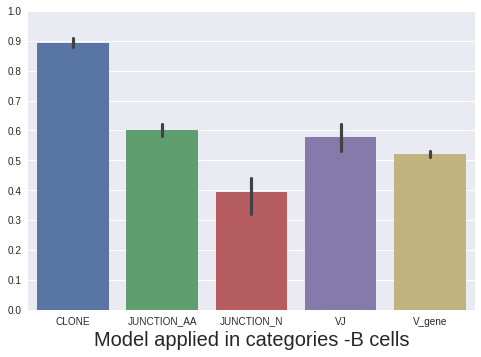

In [39]:
dict_b = {'V_gene' : [0.52,0.53,0.51] , 
'VJ' : [0.62,0.53,0.58] , 
'JUNCTION_N' : [0.32,0.42,0.44],
'JUNCTION_AA' : [0.58 , 0.62,0.6],
'CLONE' : [0.89 , 0.91 , 0.88]
         
         }

b_cat = pd.DataFrame(dict_b)
g = sns.barplot(data=b_cat)
g.set_xlabel('Model applied in categories -B cells',fontsize=20)
g.set_ylim((0,1))
g.set_yticks(list(np.arange(0,1.1,0.1)))

plt.show()

# T cells groups

In [1]:
path = '/home/bcrlab/sharaboc/'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

print ("Upload file..")
fil = pd.read_csv(path+"/clones/Unified_T.csv",sep = '\t')

def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

print ("Modify categories..")
fil['SHORT_J'] = fil.J_CALL.apply(v1)
fil['SHORT_V'] = fil.V_CALL.apply(v1)

fil = fil[fil['PRIMER'].str[:4] !='IGLC']
fil = fil[fil['FUNCTIONAL'] !='F']
fil = fil[fil.INDELS =='F']
#fil = fil[fil.CONSCOUNT>1]

fil['VJ'] = fil['SHORT_V']+'*'+fil['SHORT_J'] 
fil['VJL'] = fil['SHORT_V']+'*'+fil['SHORT_J'] +'*'+fil['JUNCTION_LENGTH'].astype(str)

fil = fil[fil['JUNCTION_LENGTH'] >12]
fil = fil[fil.JUNCTION_LENGTH%3 ==0 ]

Upload file..
Modify categories..


### Optional: estimate Junctions contained in V gene groups

In [332]:
aa = fil.groupby(['SHORT_J','JUNCTION']).size().reset_index()
asum = fil.groupby('JUNCTION').size().reset_index()
asum = asum[asum[0]>1] # Remove cases of single junction - non informative
aa_merged = aa.merge(asum,left_on='JUNCTION' , right_on = 'JUNCTION')
aa_merged['frac'] = aa_merged['0_x'] / aa_merged['0_y']

aa_maxes = aa_merged.groupby('JUNCTION')['frac'].max()

print (aa_maxes[aa_maxes ==1].count()/len(aa_maxes))

0.999909981996


In [320]:
fil = fil[fil['SHORT_V'].str[:3]!='TRA']


In [341]:
fil['VJ_long'] = fil['V_CALL']+'*'+fil['J_CALL'] 

In [6]:
fil['JUNC_AA'] = fil.JUNCTION.apply(prot)

/home/bcrlab/sharaboc/anaconda3/lib/python3.6/site-packages/Bio/Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [17]:
fil = fil[fil.JUNC_AA.apply(lambda x: 'X' not in x)]

In [25]:
run_minus(fil,'JUNC_AA',2)

Reducing
analyze cycle 0
analyze cycle 1
analyze cycle 2


### T cells , V gene:

In [335]:
run_minus(fil,'SHORT_V',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.4778761 0.5287356 

[1] "precision 0.5"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.5368421 0.4571429 

[1] "precision 0.495"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.5283019 0.4893617 

[1] "precision 0.51"



In [344]:
run_minus(fil,'SHORT_J',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.6593407 0.7247706 

[1] "precision 0.695"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.6373626 0.7155963 

[1] "precision 0.68"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.6265060 0.7179487 

[1] "precision 0.68"



In [343]:
run_minus(fil,'VJL',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.6428571 0.6465517 

[1] "precision 0.645"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.6444444 0.6454545 

[1] "precision 0.645"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.6236559 0.6448598 

[1] "precision 0.635"



### T cells,  VJ combination:

In [323]:
run_minus(fil,'VJ',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.6250000 0.4910714 

[1] "precision 0.55"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.6363636 0.5089286 

[1] "precision 0.565"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.6494845 0.5631068 

[1] "precision 0.605"



In [324]:
run_minus(fil,'JUNCTION',2)

Reducing
analyze cycle 0
[1] "Results:"



       CI        SC 

0.8604651 0.8070175 

[1] "precision 0.83"

analyze cycle 1
[1] "Results:"



       CI        SC 

0.9215686 0.7346939 

[1] "precision 0.83"

analyze cycle 2
[1] "Results:"



       CI        SC 

0.9130435 0.7407407 

[1] "precision 0.82"



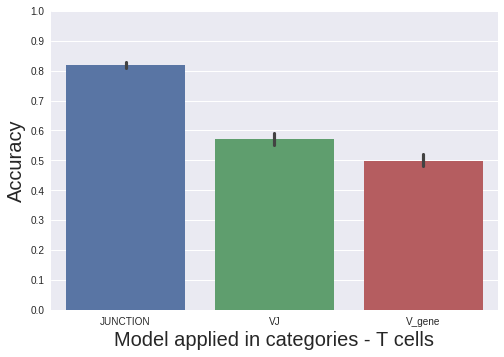

In [329]:
dict_t = {'V_gene' : [0.52,0.48,0.49] , 
'VJ' : [0.55,0.59,0.57] , 
'JUNCTION' : [0.81,0.82,0.83]
         
         }

t_cat = pd.DataFrame(dict_t)
g = sns.barplot(data=t_cat)
g.set_xlabel('Model applied in categories - T cells',fontsize=20)
g.set_ylim((0,1))
g.set_yticks(list(np.arange(0,1.1,0.1)))
g.set_ylabel('Accuracy',fontsize=20)

plt.show()

### T junction AA , SC Vs CI

In [20]:
run_minus(fil,'JUNC_AA',2)

Reducing
analyze cycle 0
        1         2 

0.5157895 0.8571429 

[1] "precision 0.695"

analyze cycle 1
        1         2 

0.5000000 0.8181818 

[1] "precision 0.675"

analyze cycle 2
        1         2 

0.4947368 0.7428571 

[1] "precision 0.625"



### T junction DNA , SC Vs CI

In [21]:
run_minus(fil,'JUNCTION',2)

Reducing
analyze cycle 0
        1         2 

0.8666667 0.8272727 

[1] "precision 0.845"

analyze cycle 1
        1         2 

0.8936170 0.7830189 

[1] "precision 0.835"

analyze cycle 2
        1         2 

0.8314607 0.8288288 

[1] "precision 0.83"



### T junction DNA - C VS SC

In [282]:
run_minus(fil,'JUNCTION',4)

Reducing
analyze cycle 0
[1] "Results:"



        C        SC 

0.5147059 0.6893939 

[1] "precision 0.63"

analyze cycle 1
[1] "Results:"



        C        SC 

0.5238095 0.6637931 

[1] "precision 0.605"

analyze cycle 2
[1] "Results:"



        C        SC 

0.5697674 0.7456140 

[1] "precision 0.67"



###  T junction DNA - C Vs CI

In [283]:
run_minus(fil,'JUNCTION',6)

Reducing
analyze cycle 0
[1] "Results:"



        C        CI 

0.0000000 0.4454545 

[1] "precision 0.245"

analyze cycle 1
[1] "Results:"



        C        CI 

0.0000000 0.3684211 

[1] "precision 0.21"

analyze cycle 2
[1] "Results:"



        C        CI 

0.0106383 0.3867925 

[1] "precision 0.21"



# B cells - taking out one sample

In [70]:
dict_subjects = {subject: by_symp(subject) for subject in fil.SUBJECT.unique()}

In [72]:
for k,v in dict_subjects.items():
    if v!='C':
        ff  = fil[fil.SUBJECT!=k]
        print (k, len(ff))
        run_minus(ff,'clon',2)
        del ff

SC2 1276293
Reducing
analyze cycle 0
        1         2 

0.7943925 0.9139785 

[1] "precision 0.85"

analyze cycle 1
        1         2 

0.8508772 0.8604651 

[1] "precision 0.855"

analyze cycle 2
        1         2 

0.7835052 0.8737864 

[1] "precision 0.83"

CI11 1255181
Reducing
analyze cycle 0
        1         2 

0.8658537 0.8728814 

[1] "precision 0.87"

analyze cycle 1
        1         2 

0.8969072 0.8737864 

[1] "precision 0.885"

analyze cycle 2
        1         2 

0.8453608 0.9223301 

[1] "precision 0.885"

SC11 1300109
Reducing
analyze cycle 0
        1         2 

0.7211538 0.5833333 

[1] "precision 0.655"

analyze cycle 1
        1         2 

0.7850467 0.6881720 

[1] "precision 0.74"

analyze cycle 2
        1         2 

0.8058252 0.7216495 

[1] "precision 0.765"

CI16 1237284
Reducing
analyze cycle 0
        1         2 

0.8217822 0.9191919 

[1] "precision 0.87"

analyze cycle 1
        1         2 

0.9010989 0.9174312 

[1] "precision 0.91"

analyz

### take one sample out - T cells DNA junction

In [12]:
path = '/home/bcrlab/sharaboc/'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

print ("Upload file..")
fil = pd.read_csv(path+"/clones/Unified_T.csv",sep = '\t')

def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

print ("Modify categories..")
fil['SHORT_J'] = fil.J_CALL.apply(v1)
fil['SHORT_V'] = fil.V_CALL.apply(v1)

fil = fil[fil['PRIMER'].str[:4] !='IGLC']
fil = fil[fil['FUNCTIONAL'] !='F']
fil = fil[fil.INDELS =='F']
#fil = fil[fil.CONSCOUNT>1]

fil['VJ'] = fil['SHORT_V']+'*'+fil['SHORT_J'] 
fil['VJL'] = fil['SHORT_V']+'*'+fil['SHORT_J'] +'*'+fil['JUNCTION_LENGTH'].astype(str)

fil = fil[fil['VJ'] != 'IGHV3-15*IGHJ6']
fil = fil[fil['JUNCTION_LENGTH'] >12]
fil = fil[fil.JUNCTION_LENGTH%3 ==0 ]

Upload file..
Modify categories..


In [76]:
dict_subjects = {subject: by_symp(subject) for subject in fil.SUBJECT.unique()}

In [77]:
for k,v in dict_subjects.items():
    if v!='C':
        ff  = fil[fil.SUBJECT!=k]
        print (k, len(ff))
        run_minus(ff,'JUNCTION',2)
        del ff

CI26 1139217
Reducing
analyze cycle 0
        1         2 

0.7974684 0.7355372 

[1] "precision 0.76"

analyze cycle 1
        1         2 

0.7594937 0.7107438 

[1] "precision 0.73"

analyze cycle 2
SC2 1148673
Reducing
analyze cycle 0
        1         2 

0.8152174 0.7777778 

[1] "precision 0.795"

analyze cycle 1
        1         2 

0.8762887 0.7087379 

[1] "precision 0.79"

analyze cycle 2
        1         2 

0.8350515 0.6699029 

[1] "precision 0.75"

CI15 1118355
Reducing
analyze cycle 0
        1         2 

0.8000000 0.7090909 

[1] "precision 0.75"

analyze cycle 1
        1         2 

0.8192771 0.7606838 

[1] "precision 0.785"

analyze cycle 2
        1         2 

0.7411765 0.7826087 

[1] "precision 0.765"

SC15 1132111
Reducing
analyze cycle 0
        1         2 

0.9176471 0.8260870 

[1] "precision 0.865"

analyze cycle 1
        1         2 

0.9550562 0.7567568 

[1] "precision 0.845"

analyze cycle 2
CI11 1106473
Reducing
analyze cycle 0
        1         

In [79]:
dict_subjects = {subject: by_symp(subject) for subject in fil.SUBJECT.unique()}

for k,v in dict_subjects.items():
    if v!='C':
        ff  = fil[fil.SUBJECT!=k]
        print (k, len(ff))
        run_minus(ff,'JUNCTION',2)
        del ff

CI26 1139217
Reducing
analyze cycle 0
        1         2 

0.7432432 0.8333333 

[1] "precision 0.8"

analyze cycle 1
        1         2 

0.7956989 0.8971963 

[1] "precision 0.85"

analyze cycle 2
        1         2 

0.7500000 0.8362069 

[1] "precision 0.8"

SC2 1148673
Reducing
analyze cycle 0
        1         2 

0.7766990 0.8041237 

[1] "precision 0.79"

analyze cycle 1
        1         2 

0.7319588 0.7475728 

[1] "precision 0.74"

analyze cycle 2
        1         2 

0.8829787 0.7735849 

[1] "precision 0.825"

CI15 1118355
Reducing
analyze cycle 0
        1         2 

0.6966292 0.8018018 

[1] "precision 0.755"

analyze cycle 1
        1         2 

0.7534247 0.8346457 

[1] "precision 0.805"

analyze cycle 2
        1         2 

0.7065217 0.8611111 

[1] "precision 0.79"

SC15 1132111
Reducing
analyze cycle 0
        1         2 

0.9101124 0.9729730 

[1] "precision 0.945"

analyze cycle 1
        1         2 

0.9042553 0.9528302 

[1] "precision 0.93"

analyze c

In [4]:
import glob
glob.glob(path+"/clones/clone*.csv")

['/home/bcrlab/sharaboc//clones/clone_leven.csv',
 '/home/bcrlab/sharaboc//clones/clones_hamming_no_isotype.csv',
 '/home/bcrlab/sharaboc//clones/clones_isotpe_hamming.csv',
 '/home/bcrlab/sharaboc//clones/clones_hamming_no_isotype_22.csv',
 '/home/bcrlab/sharaboc//clones/clones_hamming_no_isotype_3.csv',
 '/home/bcrlab/sharaboc//clones/clones_hamming_no_isotype_08.csv',
 '/home/bcrlab/sharaboc//clones/clones_hamming_no_isotype_15.csv',
 '/home/bcrlab/sharaboc//clones/clones_hamming__only_v_call_no_isotype_15.csv']

In [18]:
category = 'SHORT_V' #Change category by V/  VJ / CLONE..
ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
#fn = fn[fn['DUPCOUNT']>1]
tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
fn = fn.fillna(0)

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

fn['symp'] = fn['SUBJECT'].apply(by_symp)

In [19]:
np.shape(reduce1(fn,'SHORT_V'))

(27, 85)

In [18]:
def reduce2(fn):
    fn = fn[fn.symp!='C']
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<7].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def reduce1(fn,category):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<5].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def reduce3(fn):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<7].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

## Use the standart model ( feature selection by reandom forests) 

In [35]:
def run_minus(fil , category,towgroups):
    ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
    fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
    #fn = fn[fn['DUPCOUNT']>1]
    tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
    fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
    fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
    fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
    fn = fn.fillna(0)

    def by_symp(x):
        if x[:2] =='CI' or x[:2] =='SC':
            return  x[:2]
        if x[:1] =='C':
            return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

    fn['symp'] = fn['SUBJECT'].apply(by_symp)
    
    print ("Reducing")
    fn = reduce1(fn,category)
    fn.to_csv(path+"/ML_results/Freq_tables/B_minus_sc7.csv",sep = '\t')

    import os
    os.chdir(path+'//ML_results/Freq_tables')
    file_name = "B_minus_sc7.csv"
    group_num = towgroups
    
    for i in range(3):
        print ("analyze cycle "+str(i))
        os.system('Rscript Rscript_best_features.R '+file_name+ ' '+str(group_num)+' > out.txt')
        import re
        f_open = open('out.txt','r')
        flag = 0
        for line in f_open:
            line_s = re.split(' ',line)
            if line_s[0] =='[1]':
                flag = 1
            if flag:
                print (line)

In [259]:
file_name = "B_minus_sc7.csv"
group_num = 2

import re
f_open = open('out.txt','r')
flag = 0
for line in f_open:
    #print (line)
    line_s = re.split(' ',line)
    if line_s[0] =='[1]':
        flag = 1
    if flag:
        print (line)

[1] "Results:"



   CI    SC 

0.175 0.375 

[1] "precision 0.295"



In [17]:
fn.columnsf_classif(fn.iloc[:,1:-1],fn['symp'])[1]<0.3

array([ True, False, False, ..., False, False, False], dtype=bool)

## Use feature from naive selection of best clones: 

In [531]:
category = 'clon' #Change category by V/  VJ / CLONE..
ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
#fn = fn[fn['DUPCOUNT']>1]
tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
fn = fn.fillna(0)

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

fn['symp'] = fn['SUBJECT'].apply(by_symp)

In [533]:
#fil_best = pd.read_csv(path+"ML_results/B_10_best_features",sep = ',')
#list_best_clones_old = list(fil_best['clone'].apply(lambda x: x[:x.find('.')] +'-'+x[x.find('.')+1:].replace('.','*')))
#list_best_clones_old

In [537]:
fn = reduce1(fn , 'clon')

#fnn = fn[['SUBJECT'] +list(fn.columns.intersection(list_best_clones_old)) +['symp']]
fn.to_csv(path+"/ML_results/Freq_tables/B_best_by_naive.csv",sep = '\t')

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "B_best_by_naive.csv"
group_num = 2

for i in range(3):
    os.system('Rscript Rscript_best_features_naive.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split(' ',line)
        if line_s[0] =='[1]':
            flag = 1
        if flag:
            print (line)

[1] "Results:"



        1         2 

0.7894737 0.5428571 

[1] "precision 0.66"

[1] "Results:"



   1    2 

0.76 0.66 

[1] "precision 0.71"

[1] "Results:"



        1         2 

0.7931034 0.6194690 

[1] "precision 0.695"



### Random naive B

In [538]:
fn = reduce1(fn , 'clon')

#fnn = fn[['SUBJECT'] +list(fn.columns.intersection(list_best_clones_old)) +['symp']]
fn.to_csv(path+"/ML_results/Freq_tables/B_best_by_naive.csv",sep = '\t')

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "B_best_by_naive.csv"
group_num = 2

for i in range(3):
    os.system('Rscript Rscript_best_features_naive_random.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split(' ',line)
        if line_s[0] =='[1]':
            flag = 1
        if flag:
            print (line)

[1] "Results:"



         1          2 

0.02040816 0.45098039 

[1] "precision 0.24"

[1] "Results:"



        1         2 

0.7547170 0.2978723 

[1] "precision 0.54"

[1] "Results:"



        1         2 

0.3936170 0.3490566 

[1] "precision 0.37"



In [16]:
def filter_by_cluster(fn):
    ffc = fn.iloc[:,:-1].corr().reset_index()
    df_dists = 1 - abs(ffc.iloc[:,1:])
    df_dists = df_dists.fillna(0)
    link = hc.linkage(squareform(df_dists),"complete")
    i = hc.cut_tree(link,height=0.05)
    pds_i = df_dists.reset_index()
    dff = pd.DataFrame({ 'seq' : pds_i['index'] , 'cluster' : list(i.flatten())})
    dict_clon_num= dict(zip(pds_i['index'] , list(i.flatten())))
    clustered = df_dists.reset_index()['index'].apply(lambda x: dict_clon_num[x]).reset_index()
    dict_ind_clon = ffc.iloc[:,:1].to_dict()['clon']
    short_fn = fn[clustered.groupby('index').first().reset_index().apply(lambda x: dict_ind_clon[x.level_0],1).tolist() +['symp']]
    return short_fn


# B Mutations on V gene:

In [75]:
f1 = pd.read_csv("/home/bcrlab/sharaboc/Downloads/Mut_num_v.csv",sep = '\t')
f1['Iso-V'] = f1['PRIMER'] +'-' + f1['SHORT_V']

ff = f1.groupby(['SUBJECT','Iso-V'])['Mut_num'].mean().reset_index().pivot (index='SUBJECT' , columns='Iso-V' , values = 'Mut_num').reset_index()
ff['symp'] =ff.SUBJECT.apply(by_symp)
ff = ff[ff['symp']!='C']
#dicts = { k: {kk:vv for kk,vv in v.items() if str(vv)!='nan'} for k,v in ff.to_dict().items()  }
dicts = {gene: f_classif(ff[[gene, 'symp']].dropna().iloc[:,:1] ,ff[[gene, 'symp']].dropna()['symp'])[1][0]  for gene in ff.columns[1:-1] if np.shape(ff[[gene, 'symp']].dropna())[0]>2}

/home/bcrlab/sharaboc/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)


In [83]:
f1.groupby(['SUBJECT','Iso-V'])['Mut_num'].std()

SUBJECT  Iso-V         
C10      IGA-IGHV1-18      11.415141
         IGA-IGHV1-2        7.671976
         IGA-IGHV1-24       7.935976
         IGA-IGHV1-45       6.685748
         IGA-IGHV1-46      12.574750
         IGA-IGHV1-58      12.979703
         IGA-IGHV1-69      12.517924
         IGA-IGHV1-8        7.759960
         IGA-IGHV2-26       9.152153
         IGA-IGHV2-5        8.371008
         IGA-IGHV2-70       8.919329
         IGA-IGHV2-70D           NaN
         IGA-IGHV3-11      12.696223
         IGA-IGHV3-13      14.503201
         IGA-IGHV3-15      10.141847
         IGA-IGHV3-20       7.961331
         IGA-IGHV3-21      11.973385
         IGA-IGHV3-22            NaN
         IGA-IGHV3-23      12.032244
         IGA-IGHV3-30      15.523255
         IGA-IGHV3-30-3    19.517407
         IGA-IGHV3-33      12.454520
         IGA-IGHV3-35            NaN
         IGA-IGHV3-43      12.246322
         IGA-IGHV3-43D     18.605555
         IGA-IGHV3-48      11.977368
         IGA-I

In [92]:
f1['Iso-V'] = f1['PRIMER'] +'-' + f1['SHORT_V']

ff = f1.groupby(['SUBJECT','Iso-V'])['Mut_num'].median().reset_index() #### mean? median? std? 


df_piv = ff.pivot(index = 'SUBJECT', values = 'Mut_num' , columns = 'Iso-V').reset_index()
df_piv['symp'] = df_piv['SUBJECT'].apply(by_symp)

### Think before usage

In [91]:
pvs = pd.Series(dicts).reset_index()
pvs = pvs[(pvs[0]<0.3) & (pvs[0]>0)]

df_piv = df_piv[pvs['index'].tolist()+['symp']]  #Consider selecting only best features -> ??????????????????????

In [93]:
df_piv = df_piv.T.dropna().T
df_piv = df_piv.drop(df_piv.columns[1:-1][df_piv.iloc[:,1:-1].std() / df_piv.iloc[:,1:-1].median() < 0.1],1)
df_piv

Iso-V,SUBJECT,IGA-IGHV1-18,IGA-IGHV1-2,IGA-IGHV1-24,IGA-IGHV1-46,IGA-IGHV1-69,IGA-IGHV2-26,IGA-IGHV2-5,IGA-IGHV3-11,IGA-IGHV3-13,...,IGM-IGHV3-74,IGM-IGHV4-31,IGM-IGHV4-34,IGM-IGHV4-39,IGM-IGHV4-4,IGM-IGHV4-59,IGM-IGHV4-61,IGM-IGHV5-51,IGM-IGHV6-1,symp
0,C10,28,22,23,28,33,14,14,30,16,...,9,1,0,1,1,1,1,1,4,C
1,C4,26,22,24,26,31,12,19,25,27,...,13,2,1,8,13,11,12,8,9,C
2,C5,14,21,6,17,21,9,6,15,19,...,7,1,1,3,7,9,4,3,8,C
3,C6,25,24,21,27,26,19,20,19,19,...,10,1,0,1,1,1,8,1,7,C
4,C7,32,26,36.5,27,35,32,22,34,36.5,...,5,1,1,1,3,2,0,1,2,C
5,C8,18,24,24,26,29,15.5,16,24,15,...,14,4,1,8,7,7,9,5,7,C
6,C9,30,21.5,28,28,29,10,23,26.5,22,...,5,1,3,2,1.5,1,2,1,2,C
7,CI10,30,32,20,34,37.5,30,19,18.5,15,...,9,4.5,2,3,2,2.5,4.5,1,7.5,CI
8,CI11,23,20,25,23,25,18,18,24,29.5,...,8,3,1,5,5,5,6,3,6,CI
9,CI13,22,20,10,19,21,11,12,25,18,...,4,1,0,1,1,1,1,1,5,CI


In [94]:
df_piv.iloc[:,2:-1] = df_piv.iloc[:,2:-1].apply(lambda x: x.fillna(x.mean()))

In [95]:
df_piv.columns = [list(df_piv.columns[:-1]) + ['symp']]

In [96]:
df_piv

,SUBJECT,IGA-IGHV1-18,IGA-IGHV1-2,IGA-IGHV1-24,IGA-IGHV1-46,IGA-IGHV1-69,IGA-IGHV2-26,IGA-IGHV2-5,IGA-IGHV3-11,IGA-IGHV3-13,...,IGM-IGHV3-74,IGM-IGHV4-31,IGM-IGHV4-34,IGM-IGHV4-39,IGM-IGHV4-4,IGM-IGHV4-59,IGM-IGHV4-61,IGM-IGHV5-51,IGM-IGHV6-1,symp
0,C10,28,22,23,28,33,14,14,30,16,...,9,1,0,1,1,1,1,1,4,C
1,C4,26,22,24,26,31,12,19,25,27,...,13,2,1,8,13,11,12,8,9,C
2,C5,14,21,6,17,21,9,6,15,19,...,7,1,1,3,7,9,4,3,8,C
3,C6,25,24,21,27,26,19,20,19,19,...,10,1,0,1,1,1,8,1,7,C
4,C7,32,26,36.5,27,35,32,22,34,36.5,...,5,1,1,1,3,2,0,1,2,C
5,C8,18,24,24,26,29,15.5,16,24,15,...,14,4,1,8,7,7,9,5,7,C
6,C9,30,21.5,28,28,29,10,23,26.5,22,...,5,1,3,2,1.5,1,2,1,2,C
7,CI10,30,32,20,34,37.5,30,19,18.5,15,...,9,4.5,2,3,2,2.5,4.5,1,7.5,CI
8,CI11,23,20,25,23,25,18,18,24,29.5,...,8,3,1,5,5,5,6,3,6,CI
9,CI13,22,20,10,19,21,11,12,25,18,...,4,1,0,1,1,1,1,1,5,CI


In [97]:
df_piv.iloc[:,1:].to_csv(path+"/ML_results/Freq_tables/B_Mut.csv",sep = '\t')

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "B_Mut.csv"
group_num = 2

for i in range(3):
    os.system('Rscript Rscript_best_features.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split(' ',line)
        if line_s[0] =='[1]':
            flag = 1
        if flag:
            print (line)

[1] "Results:"



       CI        SC 

0.7669903 0.5773196 

[1] "precision 0.675"



IGA.IGHV2.26 IGA.IGHV5.51 IGG.IGHV3.33 IGA.IGHV4.59 IGG.IGHV3.43 IGG.IGHV3.21 

         100          100          100           99           97           93 

IGM.IGHV3.11  IGA.IGHV4.4 IGG.IGHV3.53 IGG.IGHV5.51 IGA.IGHV4.61 IGM.IGHV3.73 

          85           80           80           80           74           71 

IGM.IGHV1.69  IGG.IGHV1.2 IGG.IGHV1.69 IGG.IGHV3.23  IGG.IGHV2.5 IGA.IGHV3.30 

          60           54           52           52           45           41 

IGA.IGHV3.43 IGG.IGHV1.18 IGG.IGHV1.24 IGM.IGHV3.21 IGD.IGHV4.59 IGM.IGHV4.61 

          41           33           32           32           30           27 

IGM.IGHV3.43 IGA.IGHV3.49 IGA.IGHV4.39 IGA.IGHV3.21 IGA.IGHV3.73 IGE.IGHV1.69 

          23           22           22           20           17           16 

 IGM.IGHV1.2 IGG.IGHV2.26 IGG.IGHV3.49 IGM.IGHV4.39 IGG.IGHV3.11 IGA.IGHV3.11 

          13           12        

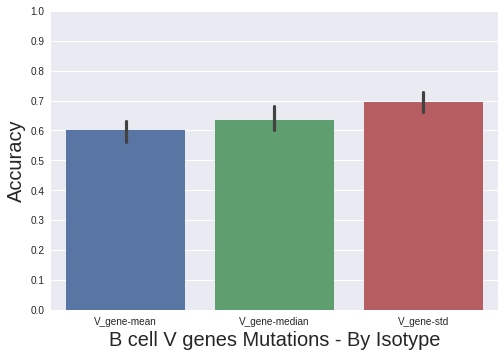

In [99]:
dict_t = {'V_gene-mean' : [0.63,0.56,0.61] , 
'V_gene-median' : [0.68,0.62,0.60] , 
'V_gene-std' : [0.66,0.73,0.7] , 

#'VJ_gene-mean' : [0.75,0.68,0.66] , 
#'VJ_gene-median' : [0.73,0.75,0.69] , 
#'VJ_gene-std' : [0.58,0.59,0.57]
         
         }

t_cat = pd.DataFrame(dict_t)
g = sns.barplot(data=t_cat)
g.set_xlabel('B cell V genes Mutations - By Isotype',fontsize=20)
g.set_ylim((0,1))
g.set_yticks(list(np.arange(0,1.1,0.1)))
g.set_ylabel('Accuracy',fontsize=20)

plt.show()

## Use feature from naive selection of T junctions: 

In [523]:
print ("Upload file..")
fil = pd.read_csv(path+"/clones/Unified_T.csv",sep = '\t')

def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

print ("Modify categories..")
fil['SHORT_J'] = fil.J_CALL.apply(v1)
fil['SHORT_V'] = fil.V_CALL.apply(v1)

fil = fil[fil['PRIMER'].str[:4] !='IGLC']
fil = fil[fil['FUNCTIONAL'] !='F']
fil = fil[fil.INDELS =='F']
#fil = fil[fil.CONSCOUNT>1]

fil['VJ'] = fil['SHORT_V']+'*'+fil['SHORT_J'] 
fil['VJL'] = fil['SHORT_V']+'*'+fil['SHORT_J'] +'*'+fil['JUNCTION_LENGTH'].astype(str)

fil = fil[fil['VJ'] != 'IGHV3-15*IGHJ6']
fil = fil[fil['JUNCTION_LENGTH'] >12]
fil = fil[fil.JUNCTION_LENGTH%3 ==0 ]


Upload file..
Modify categories..


In [524]:
category = 'JUNCTION' #Change category by V/  VJ / CLONE..
ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
#fn = fn[fn['DUPCOUNT']>1]
tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
fn = fn.fillna(0)

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

fn['symp'] = fn['SUBJECT'].apply(by_symp)

In [526]:
fn = reduce1(fn,'JUNCTION')
#fnn = fn[['SUBJECT'] +list(fn.columns.intersection(list_best_T_junc_N)) +['symp']]
fn.to_csv(path+"/ML_results/Freq_tables/T_best_by_naive.csv",sep = '\t')

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "T_best_by_naive.csv"
group_num = 2

for i in range(3):
    os.system('Rscript Rscript_best_features_naive.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split(' ',line)
        if line_s[0] =='[1]':
            flag = 1
        if flag:
            print (line)

        1         2 

0.8295455 0.8750000 

[1] "precision 0.855"

        1         2 

0.8068182 0.8750000 

[1] "precision 0.845"

        1         2 

0.8555556 0.7909091 

[1] "precision 0.82"



### Random naive T 

In [529]:
fn = reduce1(fn,'JUNCTION')
#fnn = fn[['SUBJECT'] +list(fn.columns.intersection(list_best_T_junc_N)) +['symp']]
fn.to_csv(path+"/ML_results/Freq_tables/T_best_by_naive.csv",sep = '\t')

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "T_best_by_naive.csv"
group_num = 2

for i in range(3):
    os.system('Rscript Rscript_best_features_naive_random.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split(' ',line)
        if line_s[0] =='[1]':
            flag = 1
        if flag:
            print (line)

        1         2 

0.3370787 0.4774775 

[1] "precision 0.415"

        1         2 

0.5957447 0.3962264 

[1] "precision 0.49"



## Run predictions different clustered clones frequencies

In [40]:
import os
os.chdir(path+'/clones/')

import glob
list_files = glob.glob("clone*.csv")
os.chdir(path+'/ML_results/Freq_tables')

#f = pd.read_csv(path+'/clones/clone_leven.csv' , sep = '\t')
#dict_id_sub = f.set_index('SEQUENCE_ID')[['SUBJECT']].to_dict()['SUBJECT']

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'
    
def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

def reduce1(fn):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<4].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def run_Rscript(file_name,group_num):
    os.system('Rscript Rscript_best_features.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split('"| |" "|\n',line)
        if len(line_s) >8 and line_s[8] =='1':
            flag = 1
        if flag:
            print (line)

for file_name in list_files:
    print ("Upload file.." +file_name)
    fil = pd.read_csv(path+"//clones/"+file_name,sep = '\t')



    print ("Modify categories..")
    fil['SHORT_J'] = fil.J_CALL.apply(v1)
    fil['SHORT_V'] = fil.V_CALL.apply(v1)

    fil = fil[fil['PRIMER'].str[:4] !='IGLC']
    fil = fil[fil['FUNCTIONAL'] !='F']
    fil = fil[fil.INDELS =='F']
    fil = fil[fil.CONSCOUNT>1]

    fil['VJ'] = fil['SHORT_V']+'*'+fil['SHORT_J'] 
    fil['VJL'] = fil['SHORT_V']+'*'+fil['SHORT_J'] +'*'+fil['JUNCTION_LENGTH'].astype(str)

    fil = fil[fil['VJ'] != 'IGHV3-15*IGHJ6']
    fil = fil[fil['JUNCTION_LENGTH'] >12]
    fil['SUBJECT'] = fil['SEQUENCE_ID'].apply(lambda x: dict_id_sub[x],1)
    
    category = 'clon' #Change category by V/  VJ / CLONE..
    ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
    fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
    #fn = fn[fn['DUPCOUNT']>1]
    tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
    fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
    fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
    fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
    fn = fn.fillna(0)

    fn['symp'] = fn['SUBJECT'].apply(by_symp)


    fn = reduce1(fn)
    fn.to_csv(path+"//ML_results/Freq_tables/B_leven_90_cc_gt_1.csv",sep = '\t')
    
    short_fn = filter_by_cluster(fn)
    short_fn.to_csv(path+"//ML_results/Freq_tables/B_90_cc_gt_1_clust.csv",sep = '\t')
    
    group_num = 3
    
    print("Regular:")
    if np.shape(fn)[1] < 1500:
        for k in range(3):
            run_Rscript(path+"//ML_results/Freq_tables/B_leven_90_cc_gt_1.csv",group_num)
    else :
        print ("Too many features..")
    
    print ("Clustered:")
    if np.shape(short_fn)[1] < 1500:
        for k in range(3):
            run_Rscript(path+"/ML_results/Freq_tables/B_90_cc_gt_1_clust.csv",group_num)
    else:
        print ("Too many features")
    
    

            
    
        

Upload file..clones_hamming_no_isotype_15.csv
Modify categories..
Regular:
        1         2         3 

0.1509434 0.4179104 0.2500000 

[1] "precision 0.28"

        1         2         3 

0.1304348 0.4246575 0.2345679 

[1] "precision 0.28"

        1         2         3 

0.0781250 0.5074627 0.2753623 

[1] "precision 0.29"

Clustered:
        1         2         3 

0.2000000 0.3684211 0.3924051 

[1] "precision 0.34"

        1         2         3 

0.1090909 0.2950820 0.3333333 

[1] "precision 0.26"

        1         2         3 

0.1129032 0.3733333 0.4126984 

[1] "precision 0.305"

Upload file..clones_hamming_no_isotype_08.csv
Modify categories..
Regular:
        1         2         3 

0.6800000 0.6714286 0.4750000 

[1] "precision 0.595"

        1         2         3 

0.4705882 0.6000000 0.5652174 

[1] "precision 0.555"

        1         2         3 

0.4727273 0.7727273 0.5063291 

[1] "precision 0.585"

Clustered:
        1         2         3 

0.3333333 0.676056

## Run predictions for different clustered clones frequencies WHEN clustered by features correlations

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'
    
def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

def reduce1(fn):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<4].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def run_Rscript(file_name,group_num):
    os.system('Rscript Rscript_best_features.R '+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split('"| |" "|\n',line)
        if len(line_s) >8 and line_s[8] =='1':
            flag = 1
        if flag:
            print (line)

for file_name in list_files:
    print ("Upload file.." +file_name)
    fil = pd.read_csv("/home/bcrlab/sharaboc/clones/"+file_name,sep = '\t')



    print ("Modify categories..")
    fil['SHORT_J'] = fil.J_CALL.apply(v1)
    fil['SHORT_V'] = fil.V_CALL.apply(v1)

    fil = fil[fil['PRIMER'].str[:4] !='IGLC']
    fil = fil[fil['FUNCTIONAL'] !='F']
    fil = fil[fil.INDELS =='F']
    #fil = fil[fil.CONSCOUNT>1]

    fil['VJ'] = fil['SHORT_V']+'*'+fil['SHORT_J'] 
    fil['VJL'] = fil['SHORT_V']+'*'+fil['SHORT_J'] +'*'+fil['JUNCTION_LENGTH'].astype(str)

    fil = fil[fil['VJ'] != 'IGHV3-15*IGHJ6']
    fil = fil[fil['JUNCTION_LENGTH'] >12]

    category = 'clon' #Change category by V/  VJ / CLONE..
    ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
    fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
    #fn = fn[fn['DUPCOUNT']>1]
    tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
    fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
    fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
    fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
    fn = fn.fillna(0)

    fn['symp'] = fn['SUBJECT'].apply(by_symp)


    fn = reduce1(fn)
    fn.to_csv("/home/bcrlab/sharaboc/ML_results/Freq_tables/B_leven_90_cc_gt_1.csv",sep = '\t')
    
    short_fn = filter_by_cluster(fn)
    short_fn.to_csv("/home/bcrlab/sharaboc/ML_results/Freq_tables/B_90_cc_gt_1_clust.csv",sep = '\t')
    
    group_num = 2
    
    print("Regular:")
    if np.shape(fn)[1] < 1500:
        run_Rscript("/home/bcrlab/sharaboc/ML_results/Freq_tables/B_leven_90_cc_gt_1.csv",group_num)
    else :
        print ("Too many features..")
    
    print ("Clustered:")
    if np.shape(short_fn)[1] < 1500:
        run_Rscript("/home/bcrlab/sharaboc/ML_results/Freq_tables/B_90_cc_gt_1_clust.csv",group_num)
    else:
        print ("Too many features")
    
    


Upload file..clones_hamming_no_isotype.csv
Modify categories..
Regular:
        1         2 

0.8421053 0.8857143 

[1] "precision 0.865"

Clustered:
        1         2 

0.7127660 0.7735849 

[1] "precision 0.745"

Upload file..clones_isotpe_hamming.csv
Modify categories..
Regular:
Clustered:
        1         2 

0.6666667 0.9181818 

[1] "precision 0.805"

Upload file..clones_hamming_no_isotype_22.csv
Modify categories..
Regular:
Too many features..
Clustered:
Too many features
Upload file..clones_hamming_no_isotype_3.csv
Modify categories..
Regular:
Too many features..
Clustered:
Too many features
Upload file..clones_hamming_no_isotype_08.csv
Modify categories..
Regular:
        1         2 

0.9024390 0.7627119 

[1] "precision 0.82"

Clustered:
        1         2 

0.8470588 0.6000000 

[1] "precision 0.705"

Upload file..clones_hamming_no_isotype_15.csv
Modify categories..
Regular:
        1         2 

0.7472527 0.9174312 

[1] "precision 0.84"

Clustered:
        1         2

## Cluster T junctions by sequences - with different distance threshold

In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

print ("Upload file..")
fil = pd.read_csv(path+"//clones/Unified_T.csv",sep = '\t')

def v1 (x):
    if x.find('*') ==-1:
        return x
    return x[:x.find('*')]

print ("Modify categories..")
fil['SHORT_J'] = fil.J_CALL.apply(v1)
fil['SHORT_V'] = fil.V_CALL.apply(v1)

fil = fil[fil['PRIMER'].str[:4] !='IGLC']
fil = fil[fil['FUNCTIONAL'] !='F']
fil = fil[fil.INDELS =='F']
#fil = fil[fil.CONSCOUNT>1]


fil = fil[fil['JUNCTION_LENGTH'] >12]
fil = fil[fil.JUNCTION_LENGTH %3 ==0]

Upload file..
Modify categories..


In [422]:
category = 'JUNCTION' #Change category by V/  VJ / CLONE..
ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
#fn = fn[fn['DUPCOUNT']>1]
tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
fn = fn.fillna(0)

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

fn['symp'] = fn['SUBJECT'].apply(by_symp)

In [423]:

def reduce3(fn):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<3].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def reduce2(fn):
    #fn = fn[fn.symp!='C']
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<7].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

def reduce1(fn):
    df_bests1 = fn[fn ==0].fillna(1).sum()
    df_bests1 = fn.drop(df_bests1[df_bests1<5].index,1)
    df_fraction = df_bests1.iloc[:,1:-1]/df_bests1.iloc[:,1:-1].sum()
    df_fraction = df_fraction.max().reset_index()
    list_freq = list(df_fraction[df_fraction[0] > 0.9][category]) # Or 0.95? More less?
    df_bests1 = df_bests1.drop(list_freq,1) # Allow to remove feature with median frequency < 10^-6
    return df_bests1

In [424]:
#fn = reduce1(fn)

#### Cluster features within X (variable) dist and select 1 feature for each clone:

In [425]:
fn = reduce3(fn)

fn = fn.drop('SUBJECT',1)

import Levenshtein as lv
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform


list_dict= {}
for i,junc1 in enumerate(fn.columns.tolist()[:-1]):
    list_dict[junc1] = {}
    for junc2 in fn.columns.tolist()[:-1]:
        list_dict[junc1][junc2] = lv.distance (junc1,junc2)/max(len(junc1),len(junc2))
df_dists = pd.DataFrame(list_dict)


df_dists = df_dists.fillna(0)
link = hc.linkage(squareform(df_dists),"complete")
i = hc.cut_tree(link,height=0.05)
pds_i = df_dists.reset_index()
dict_clon_num= dict(zip(pds_i['index'] , list(i.flatten())))
clustered = df_dists.reset_index()['index'].apply(lambda x: dict_clon_num[x]).reset_index()
dict_ind_clon = {n:i for n,i in enumerate(df_dists.columns)}
short_fn = fn[clustered.groupby('index').first().reset_index().apply(lambda x: dict_ind_clon[x.level_0],1).tolist() +['symp']]

In [426]:
clustered['JUNCTION'] = clustered.apply(lambda x: dict_ind_clon[x.level_0],1)

In [427]:
dict_junc_clust = clustered[['index','JUNCTION']].set_index('JUNCTION').to_dict()['index']

In [428]:
dict_junc_clust

{'AACACTGAAGCTTTCTTT': 0,
 'AATCAGCCCCAGCATTTT': 1,
 'AATGAGCAGTTCTTC': 2,
 'ACTGAAGCTTTCTTT': 3,
 'AGAGGACCTGAAAAA': 4,
 'AGAGTGGCTATATTCTTATGTGCTAACTATGGCTACACCTTC': 5,
 'AGCGAAGGGGCTGGTCTTCTCCAGTACCCACCCCTC': 6,
 'AGTGTCCCTTTTAGAGTGGCTATATTCTTATGTGCTAACTATGGCTACACCTTC': 7,
 'CAGCCCCAGCATTTT': 8,
 'CCCTGGCTCCAACCCCTC': 9,
 'GAAGGGGCTGGTCTTCTCCAGTACCCACCCCTC': 10,
 'GACCACGTGGAGCTGAGCTGGTGG': 11,
 'GACGAAGGGGCTGGTCTTCTCCAGTACCCACCCCTC': 12,
 'GATACGCAGTATTTT': 13,
 'GGCGAAAGGGCTGGTCTTCTCCAGTACCCACCCCTC': 14,
 'GGCGAAGAAGCTGGTCTTCTCCAGTACCCACCCCTC': 15,
 'GGCGAAGAGGCTGGTCTTCTCCAGTAC': 16,
 'GGCGAAGAGGCTGGTCTTCTCCAGTACCCACCCCTC': 17,
 'GGCGAAGCGGCTGGTCTTCTCCAGTACCCACCCCTC': 18,
 'GGCGAAGCTGGTCTTCTCCAGTACCCACCCCTC': 19,
 'GGCGAAGGAGCTGGTCTTCTCCAGTACCCACCCCTC': 20,
 'GGCGAAGGCGCTGGTCTTCTCCAGTACCCACCCCTC': 21,
 'GGCGAAGGGACTGGTCTTCTCCAGTACCCACCCCTC': 22,
 'GGCGAAGGGGCTAGTCTTCTCCAGTACCCACCCCTC': 23,
 'GGCGAAGGGGCTGGACTTCTCCAGTACCCACCCCTC': 24,
 'GGCGAAGGGGCTGGCCTTCTCCAGTACCCACCCCTC': 25,
 '

In [429]:

fil['JUNCTION_CLUST'] = fil.JUNCTION.apply(lambda x: str(dict_junc_clust[x])+'_c' if x in dict_junc_clust.keys() else x)

In [430]:
category = 'JUNCTION_CLUST' #Change category by V/  VJ / CLONE..
ff = fil.groupby(['SUBJECT',category]).count().reset_index() # Use sum for DUPCOUNTS , count for ignoring DUPCOUNTS
fn = ff[list(ff.columns)[:2] +['DUPCOUNT']] # Make sure that first 2 and DUPCOUNT columns are selected
#fn = fn[fn['DUPCOUNT']>1]
tot = fn.groupby('SUBJECT')['DUPCOUNT'].sum().reset_index()
fn = fn.merge(tot,left_on = 'SUBJECT', right_on='SUBJECT')
fn['freq'] = fn['DUPCOUNT_x']/fn['DUPCOUNT_y']
fn = fn.pivot(index='SUBJECT',columns=category,values='freq').reset_index()
fn = fn.fillna(0)

def by_symp(x):
    if x[:2] =='CI' or x[:2] =='SC':
        return  x[:2]
    if x[:1] =='C':
        return 'C' ################## Important: Return 'SC' to Unify SC and C, else return 'C'

fn['symp'] = fn['SUBJECT'].apply(by_symp)

In [431]:
fn = reduce1(fn)

In [432]:
np.shape(fn)

(27, 216)

In [433]:
dict_back = {colname:k for colname in fn.columns for k,v in dict_clon_num.items() if str(v) == colname[:-2] }

In [434]:
fn.columns = fn.columns.map(lambda x: dict_back[x] if x in dict_back.keys() else x)

In [435]:
np.shape(fn)

(27, 216)

In [436]:
fn.to_csv('T_clust_short_00.csv',sep = '\t')

### Genereate prediction - no clustering:

In [437]:

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "T_clust_short_00.csv"
group_num = 2

for jj in range(3):
    os.system('Rscript Rscript_best_features.R /home/yaarilab/Desktop//ML_results/Freq_tables/'+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split('"| |" "|\n',line)
        if len(line_s) >8 and line_s[8] =='1':
            flag = 1
        if flag:
            print (line)


        1         2 

0.8888889 0.7524752 

[1] "precision 0.82"

        1         2 

0.8282828 0.7821782 

[1] "precision 0.805"

        1         2 

0.8604651 0.7543860 

[1] "precision 0.8"



### dist < 0.05

In [419]:

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "T_clust_short_005.csv"
group_num = 2

for jj in range(3):
    os.system('Rscript Rscript_best_features.R /home/yaarilab/Desktop//ML_results/Freq_tables/'+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split('"| |" "|\n',line)
        if len(line_s) >8 and line_s[8] =='1':
            flag = 1
        if flag:
            print (line)

        1         2 

0.8214286 0.7586207 

[1] "precision 0.785"

        1         2 

0.8202247 0.6486486 

[1] "precision 0.725"

        1         2 

0.7802198 0.6972477 

[1] "precision 0.735"



### dist < 0.1

In [418]:
import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "T_clust_short_01.csv"
group_num = 2

for jj in range(3):
    os.system('Rscript Rscript_best_features.R /home/yaarilab/Desktop//ML_results/Freq_tables/'+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split('"| |" "|\n',line)
        if len(line_s) >8 and line_s[8] =='1':
            flag = 1
        if flag:
            print (line)

        1         2 

0.6024096 0.7948718 

[1] "precision 0.715"

        1         2 

0.6428571 0.7538462 

[1] "precision 0.715"

        1         2 

0.5862069 0.7522124 

[1] "precision 0.68"



### dist < 0.15

In [438]:

import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "T_clust_short_015.csv"
group_num = 2

for jj in range(3):
    os.system('Rscript Rscript_best_features.R /home/yaarilab/Desktop//ML_results/Freq_tables/'+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split('"| |" "|\n',line)
        if len(line_s) >8 and line_s[8] =='1':
            flag = 1
        if flag:
            print (line)

        1         2 

0.6842105 0.7809524 

[1] "precision 0.735"

        1         2 

0.6000000 0.8173913 

[1] "precision 0.725"

        1         2 

0.6842105 0.8571429 

[1] "precision 0.775"



### dist < 0.2

In [60]:
import os
os.chdir(path+'//ML_results/Freq_tables')
file_name = "T_clust_short_02.csv"
group_num = 2

for jj in range(3):
    os.system('Rscript Rscript_best_features.R /home/yaarilab/Desktop//ML_results/Freq_tables/'+file_name+ ' '+str(group_num)+' > out.txt')
    import re
    f_open = open('out.txt','r')
    flag = 0
    for line in f_open:
        line_s = re.split('"| |" "|\n',line)
        if len(line_s) >8 and line_s[8] =='1':
            flag = 1
        if flag:
            print (line)

        1         2 

0.4791667 0.7211538 

[1] "precision 0.605"

        1         2 

0.5662651 0.6752137 

[1] "precision 0.63"

        1         2 

0.6590909 0.7589286 

[1] "precision 0.715"

